## Week 11 Solution to Application 1: Particle size in SiC - Al MMC

#### Load packages

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage import io, color, measure
import pandas as pd

from PIL import Image
from IPython.display import display

from pathlib import Path

In [40]:
#img = cv.imread("grains callister.png")
#img=img[8:270, 10:230]
img=cv.imread('../../images/30 v SiC Al matrix.jpg')
#img=img[0:400, :]
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
img_shift=cv.pyrMeanShiftFiltering(img, 9, 21)  #acts on original image

gray=cv.cvtColor(img_shift,cv.COLOR_BGR2GRAY) #move img to gray scale
blur=cv.GaussianBlur(gray,(3,3),0) # acts on gray scale image

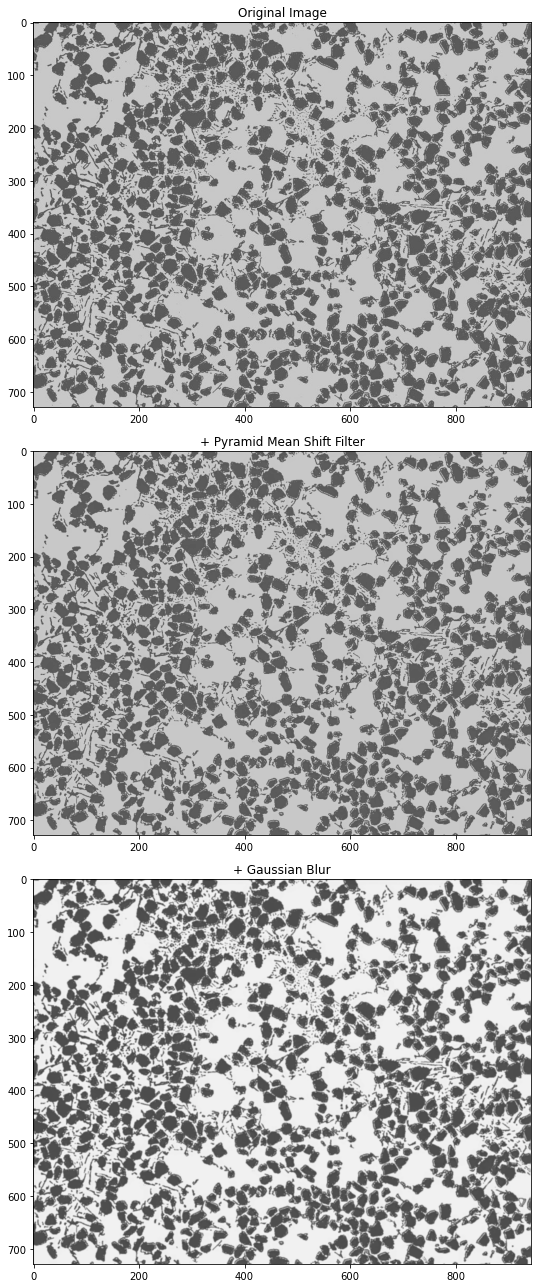

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize=(8, 18))
ax1.imshow(img)
ax2.imshow(gray, cmap='gray')
ax3.imshow(blur, cmap='gray')
ax1.set_title('Original Image')
ax2.set_title('+ Pyramid Mean Shift Filter')
ax3.set_title('+ Gaussian Blur')
plt.tight_layout()

#### Now threshold our image to black (0) & white (255) 

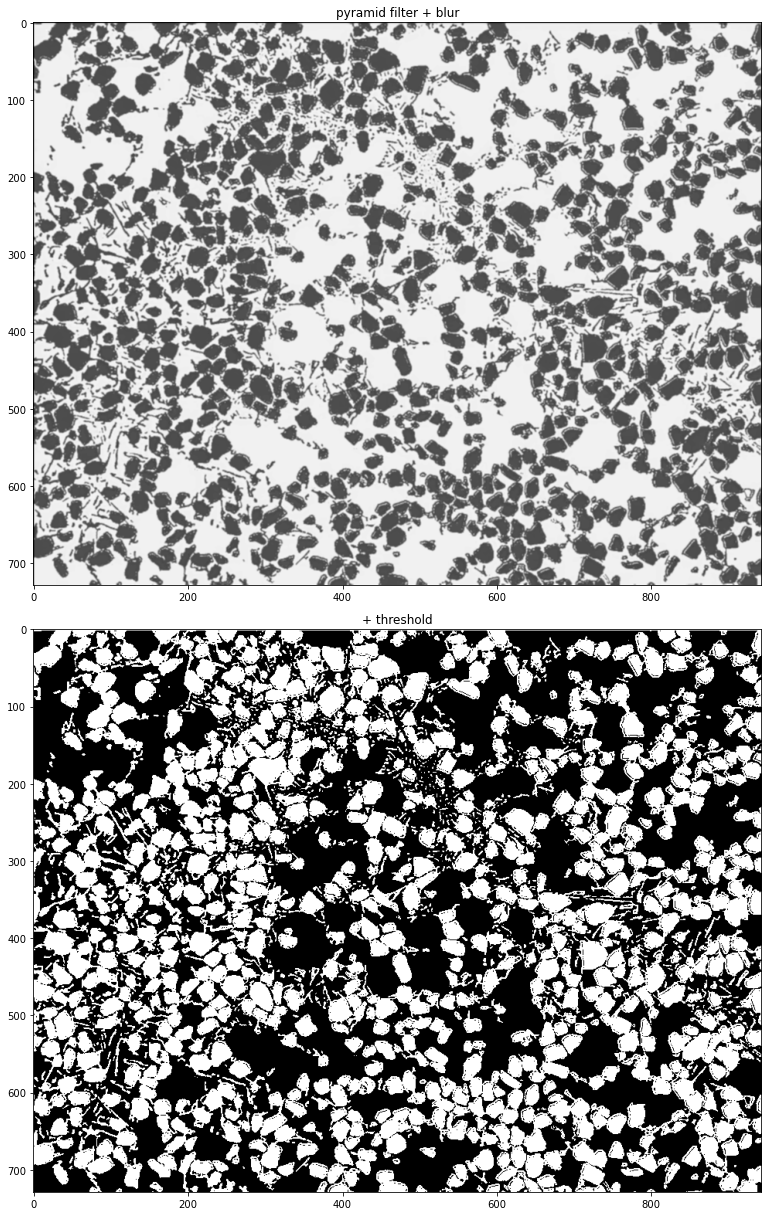

In [45]:
image_to_threshold=gray

#************** 3 choices here for performing threshold *********************
#ret, thresh = cv.threshold(image_to_threshold,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
ret, thresh = cv.threshold(image_to_threshold,165,255,cv.THRESH_BINARY_INV)
#thresh= cv.adaptiveThreshold(image_to_threshold, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV, 27, 0)
#thresh = cv.adaptiveThreshold(image_to_threshold,220,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,5) # notice using gray here not img

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,figsize=(14, 17))
ax1.imshow(blur, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax1.set_title('pyramid filter + blur')
ax2.set_title('+ threshold')

plt.tight_layout()

#### Now define a few images we  need to apply our watershed routine. 

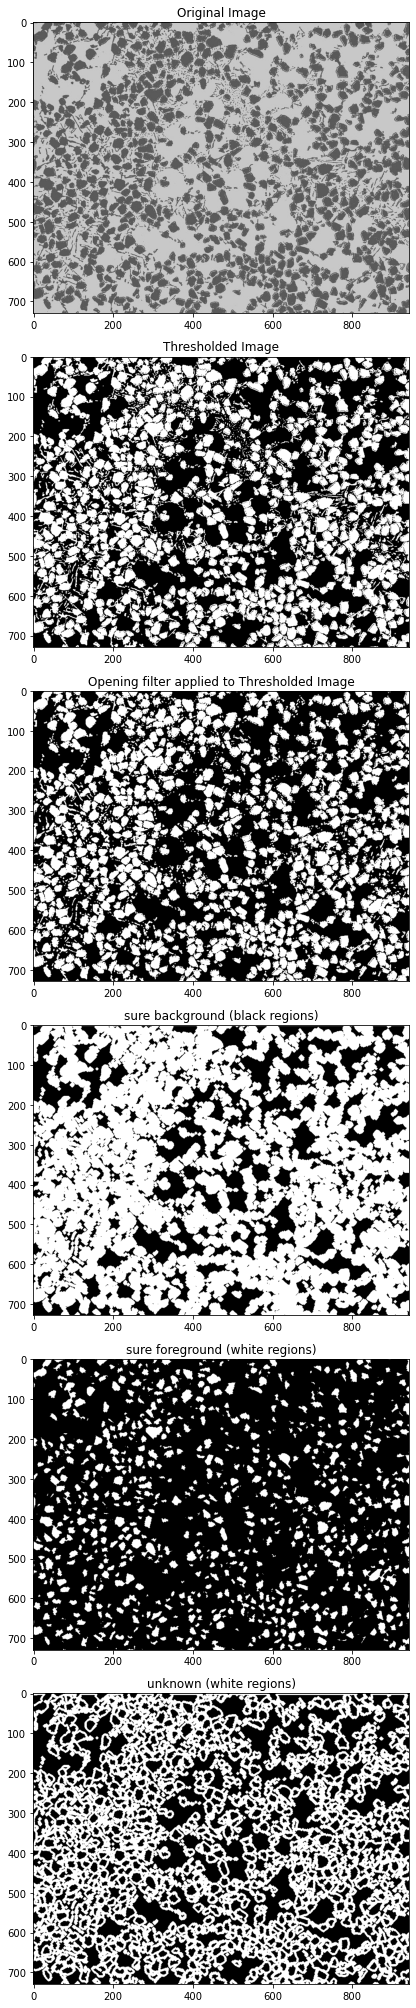

In [46]:
kernel=cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
#kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
# kernel=cv.getStructuringElement(cv.MORPH_RECT,(3,3))

# noise removal
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations=1)

# sure background area
#sure_bg = cv.dilate(opening,kernel,iterations=2)

bgt = cv.dilate(opening,kernel,iterations = 3)
ret,sure_bg = cv.threshold(bgt,1,128,1)

sure_bg=bgt

# Finding sure foreground area
sure_fg = cv.erode(opening,kernel,iterations=3)

# Finding unknown region
unknown = cv.subtract(sure_bg,sure_fg)
#unknown=cv.add(sure_fg,sure_bg)


# ******************* Display results of each step ********************

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1,figsize=(8, 28))
ax1.imshow(img, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax3.imshow(opening, cmap='gray')
ax4.imshow(sure_bg, cmap='gray')
ax5.imshow(sure_fg, cmap='gray')
ax6.imshow(unknown, cmap='gray')

ax1.set_title('Original Image')
ax2.set_title('Thresholded Image')
ax3.set_title('Opening filter applied to Thresholded Image')
ax4.set_title('sure background (black regions)')
ax5.set_title('sure foreground (white regions)')
ax6.set_title('unknown (white regions)')
plt.tight_layout()

In [21]:
unknown

array([[  0, 255, 255, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

#### Label groups of connected pixels with integers (labels)

In [47]:
# Marker labelling
# cv2.connectedComponents(). labels background of the image with 0, 
#then other objects are labelled with integers starting from 1.
ret, markers = cv.connectedComponents(sure_fg)
# bw_unknown=unknown
# bw_unknown[bw_unknown==128]=0
# ret, markers = cv.connectedComponents(bw_unknown)
# marker1=markers

In [23]:
markers

array([[1, 0, 0, ..., 9, 9, 9],
       [1, 0, 0, ..., 9, 9, 9],
       [0, 0, 0, ..., 9, 9, 9],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

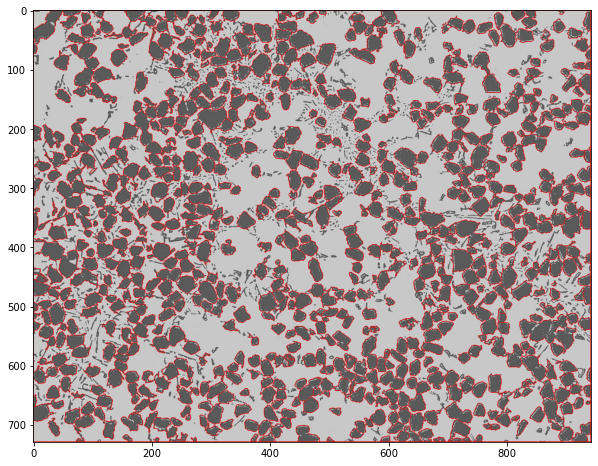

In [48]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)  # img needs shape (pix, pix, 3), markers is (pix, pix)

img[markers ==-1] = [255,0,0]

#display(Image.fromarray(markers))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot

ax.imshow(img)

plt.show()


#### Change the marker labels to colors and combine with the original image

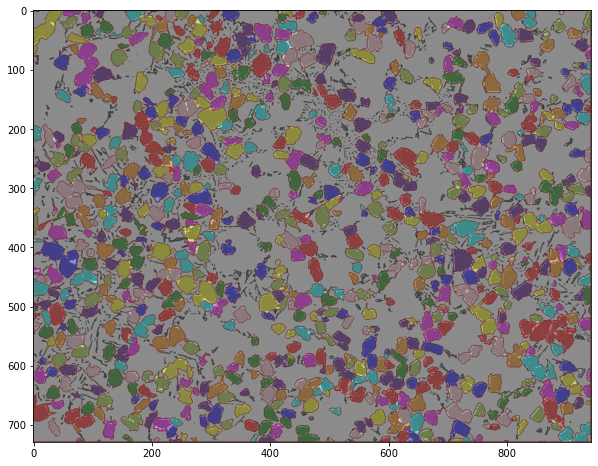

In [148]:
img2=color.label2rgb(markers, image=img, bg_label=1, alpha=0.3)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(img2);
plt.show()

#### Each colored grain can now be analyzed and placed in a Pandas DataFrame

In [74]:
pixels_to_μm=5  # μm per pixel
propList=['label','eccentricity','centroid','area','equivalent_diameter','orientation','major_axis_length', 'minor_axis_length','perimeter']
#propList=['equivalent_diameter','orientation','area','major_axis_length']
props=measure.regionprops_table(markers, properties=propList)

grain_data=pd.DataFrame(props)

grain_data.head()

label  eccentricity  centroid-0  centroid-1    area  equivalent_diameter  \
0      1      0.622749  356.046084  475.897686  382908           698.236069   
1      3      0.929304   27.283630   23.316045    1234            39.638083   
2      4      0.946540    4.339901   63.561576     203            16.076928   
3      6      0.674645    2.125000  101.500000       8             3.191538   
4      7      0.635072    5.513514  111.304054     148            13.727325   

   orientation  major_axis_length  minor_axis_length     perimeter  
0    -1.505788        1076.740244         842.465282  55042.475934  
1    -0.662502          68.875246          25.436718    184.166522  
2    -1.490350          29.581268           9.542489     70.627417  
3    -0.964783           3.752200           2.769657      7.035534  
4     1.485360          16.263049          12.562441     49.213203

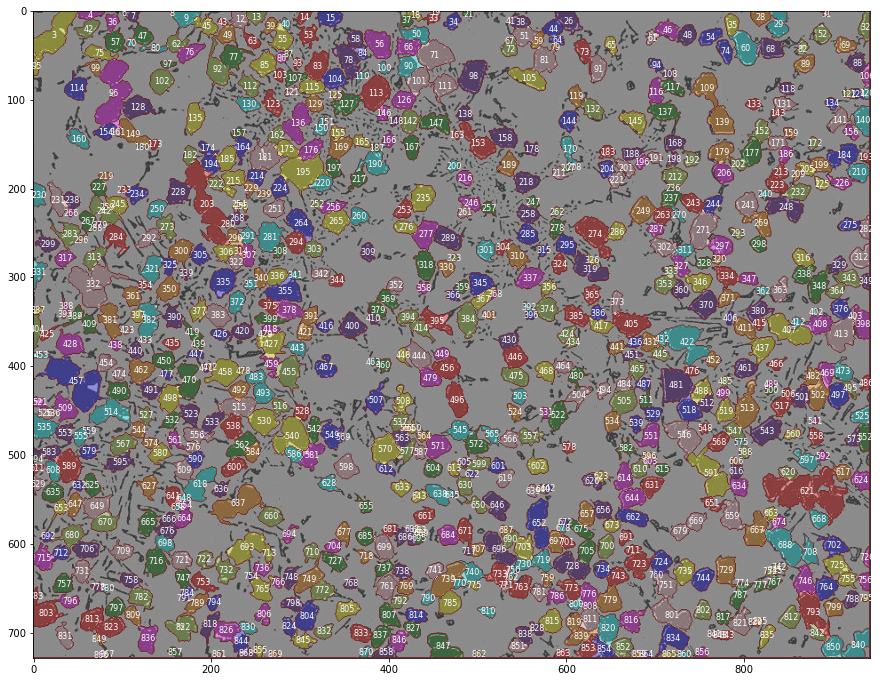

In [149]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(img2);
[ax.annotate(f'{label:0.0f}', xy=(posx, posy), c='white',fontsize=8, horizontalalignment='center', verticalalignment='center') for label, posx, posy in np.array(grain_data.loc[1:,['label','centroid-1','centroid-0']])]

plt.show()

In [174]:
# angle relative to the vertical
tt=grain_data[grain_data['label']==105]
print(*tt['orientation']*180/np.pi)
tt

67.68710500354364


label  eccentricity  centroid-0  centroid-1  area  equivalent_diameter  \
91    105      0.929331   76.232598  558.183362   589            27.384998   

    orientation  major_axis_length  minor_axis_length   perimeter  
91     1.181363          46.512558          17.174627  118.296465

<AxesSubplot:>

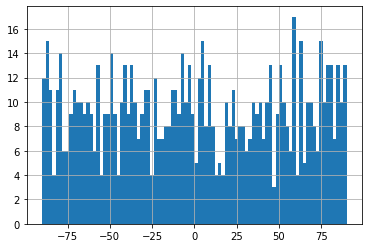

In [180]:
(grain_data['orientation']*180/np.pi).hist(bins=90)

In [70]:
#number of particles
len(grain_data.loc[1:, 'label'])

846

<AxesSubplot:>

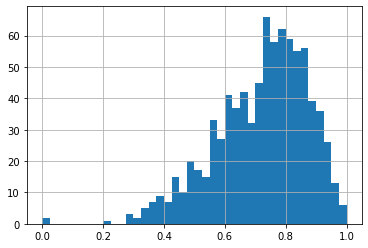

In [71]:
grain_data.loc[1:, 'eccentricity'].hist(bins=40)

<AxesSubplot:>

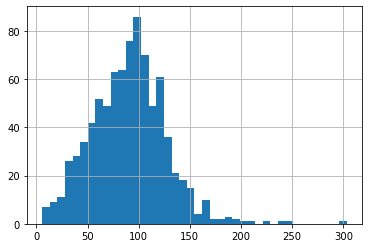

In [72]:
(grain_data.loc[1:, 'equivalent_diameter']*pixels_to_μm).hist(bins=40)

In [73]:
background_pix=len(markers[markers==1])
interface_pix=len(markers[markers==-1])
particles_pix=len(markers[markers>1])
total_pix=background_pix+interface_pix+particles_pix

print(f'total pixels = {total_pix}')
print(f'interface % = {interface_pix/total_pix*100:0.1f}%')
#giving half of the interface pixels to background and half to proeutectoid ferrite: 
print('Give half of the interface pixs to each of the following:')
print(f'background % = {(background_pix+interface_pix/2)/total_pix*100:0.1f}%')
print(f'particles % = {(particles_pix+interface_pix/2)/total_pix*100:0.1f}%')

mean_particle=(grain_data.loc[1:,'equivalent_diameter']*pixels_to_μm).mean()
print(f'avg particle diameter = {mean_particle}')

total pixels = 687438
interface % = 7.7%
Give half of the interface pixs to each of the following:
background % = 59.5%
particles % = 40.5%
avg particle diameter = 90.30941285134945
